In [1]:
import collections 
import os
import json
import typing as T

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import rectangle

from fastai.vision.all import *
from fastai.vision import *

In [2]:
torch.cuda.empty_cache()

In [3]:
# !pip install scikit-image

# Data processing

#### Utility functions

*written through pain and blood*

In [4]:
def get_label_fname(label: str) -> str:
    """Getting json file name for labels
    :param label: `train` or `test`
    """
    return f"{label}/{label}_labels.json"

def get_annotations(label_file: str) -> T.Dict[str, dict]:
    """Load all annotations for label
    :param label_file: json file name
    :returns: annotations
    """
    with open(label_file) as json_file:
        annotations = json.load(json_file)
        
        # don't need the dict keys
        annotations = list(annotations.values())
        return annotations
    
def get_figure(cx, cy, length: int, shape):
    """Returns figure around one dot. 
    """
    return rectangle(
        (cx - length//2, cy - length//2), 
        extent=(length, length), 
        shape=shape
    )
    
def get_mask(label: str, annotation: dict, side_length: int = 10) -> PILImage:
    """Creating a mask for one annotation. 
    We are having dots for marked iron bars, and for segmentation to work better we need to expand it.
    
    :param label: `train` or `test`
    :param annotation: parsed annotation dict
    :param side_length: length of the square around the dot
    :returns: mask image
    """
    img = PILImage.create(Path(label) / annotation['filename'])
    original_size = img.size

    # creating empty image(read background) with size of original image
    img = np.zeros(original_size, dtype=np.uint8)
    # get all x, y coordinates for regions
    coords = [(
        int(r['shape_attributes']['cx']), int(r['shape_attributes']['cy'])) for r in annotation['regions'].values()]
    # put coordinates on the empty background, creating a mask
    for (cy, cx) in coords:
        rr, cc = get_figure(cx, cy, side_length, original_size)
        img[rr, cc] = 1

    return img

def annotations_to_map(annotations: dict) -> T.Dict[str, dict]:
    """Utility function to re-map annotations to filename.
    """
    result = {}
    for a in annotations:
        result[a['filename']] = a
    return result

In [5]:
fname = get_label_fname('train')
train_annotations = get_annotations(fname)

In [6]:
counts = [len(a['regions']) for a in train_annotations]
c = collections.Counter(counts)

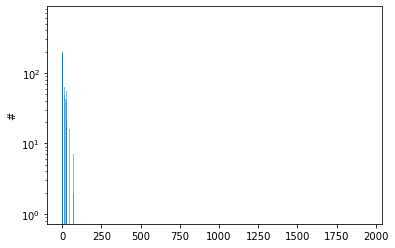

In [7]:
plt.bar(c.values(), c.keys(), align='center', alpha=0.5, log=True)
plt.ylabel('#')
plt.show()

In [8]:
c.most_common(10)

[(0, 1941),
 (3, 89),
 (4, 88),
 (1, 87),
 (5, 80),
 (7, 72),
 (2, 72),
 (8, 65),
 (6, 63),
 (12, 55)]

In [9]:
max(c)

637

In [10]:
def label_func(fn: Path) -> Path: 
    return Path('mask')/f'{fn.stem}.png'

def get_y_for_label(label: str, side_length: int = 10):
    """Returns get_y function for dataset
    :param label: dataset label
    :param side_length: length of the side of the figure
    """
    fname = get_label_fname(label)
    annotations = get_annotations(fname)
    annotations_map = annotations_to_map(annotations)   
    
    def get_y(fn):
        annotation = annotations_map[fn.name]
        mask = get_mask(label, annotation, side_length)
        msk_img = PILMask.create(mask)
        return msk_img
    return get_y

def get_codes() -> np.array:
    """Return codes of the labels
    Remember:
    0 -> Background
    1 -> iron bar
    """
    return np.array(["Background", "iron bar"])

def get_dls(label: str, side_length: int = 10) -> DataLoaders:
    """Get dataloader for label
    :param label: `train` or `test`
    :param side_length: length of the side of the figure
    """
    codes = get_codes()
    db = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes)),
        get_items=get_image_files,
        splitter=RandomSplitter(),
        get_y=get_y_for_label(label, side_length),
        item_tfms=Resize(224),
        batch_tfms=[Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(Path(label), bs=8)
    return dls

In [11]:
dls = get_dls('train')

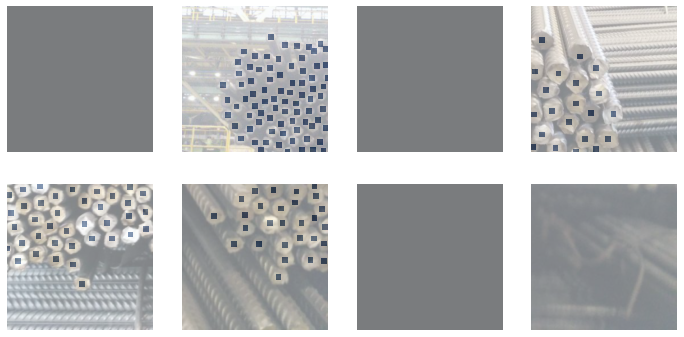

In [12]:
dls.show_batch(cmap='Blues', max_n=10, vmin=0, vmax=1)

Seem ok, maybe need to revisit figure type and size of it - I see some of them are overlapping

# Modeling

In [13]:
EPSILON = 1e-10

def _error(y_true, y_pred) -> tensor:
    """Simple error
    """
    return y_true - y_pred

def mae(y_true, y_pred):
    """Mean Absolute Error 
    """
    return torch.mean(torch.abs(_error(y_true, y_pred)))

def mape(y_true, y_pred) -> tensor:
    """
    Computes mean absolute percentage error (MAPE) but with epsilon to overcome the mape limitation
    `targ` when `pred` is bs * n_classes"
    Result is NOT multiplied by 100
    """
    y_true = y_true[:,1,:, :]
    return torch.mean(torch.abs(_error(y_true, y_pred) / (y_true + EPSILON)))

def maape(y_true, y_pred):
    """
    Mean Arctangent Absolute Percentage Error
    MAAPE is a slope as an angle, while MAPE is a slope as a ratio.
    Result is NOT multiplied by 100
    """
    return torch.mean(torch.arctan(torch.abs((y_true - y_pred) / (y_true + EPSILON))))


def get_model(metric='mape'):
    """Simple function for creating model with different metrics
    """
    metric = mape if metric=='mape' else maape
    return unet_learner(dls, models.resnet34, metrics=metric)

In [14]:
# just in case
torch.cuda.empty_cache()

In [15]:
learn = get_model()

In [16]:
learn.to_fp16()
learn.fine_tune(1)

epoch,train_loss,valid_loss,mape,time
0,0.049934,0.042195,873.356934,03:04


epoch,train_loss,valid_loss,mape,time
0,0.033605,0.032149,2399.712891,03:14


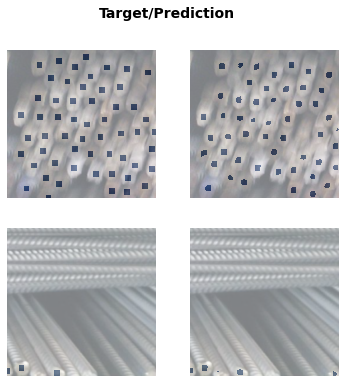

In [17]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [27]:
preds = learn.get_preds()

In [28]:
# result is a mask with two layers for two labels
preds[0][0].shape

torch.Size([2, 224, 224])

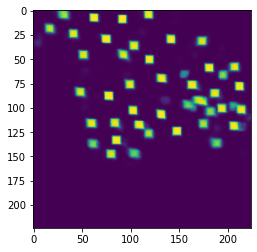

In [33]:
plt.imshow(preds[0][20][1])

# On test

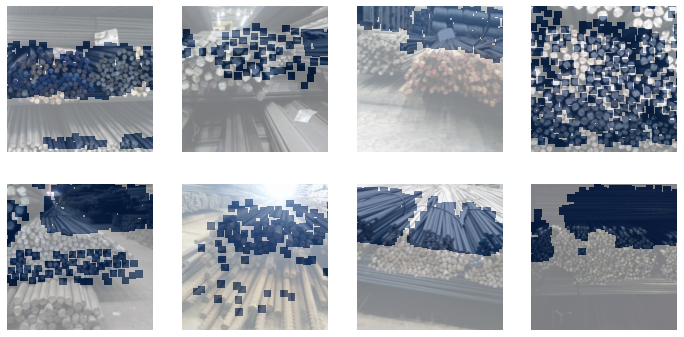

In [22]:
test_dls = get_dls('test', (4160//256) * 10) # <-- scaling figure size
test_dls.show_batch(cmap='Blues', max_n=10, vmin=0, vmax=1)

Not sure if data is fine here. Probably because of the coordinates:
`"cx":1217.4375,"cy":1443.1875`

In [23]:
preds = learn.get_preds(dl=test_dls[0])

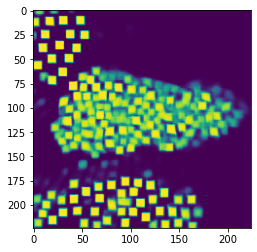

In [24]:
plt.imshow(preds[0][0][1])

# Detection

A Blob is a group of connected pixels in an image that share some common property ( E.g grayscale value ). 

In our case the regions are blobs, and the goal of blob detection is to identify these regions. And after that we gonna count them.

In [25]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

<ipython-input-26-2ee4e1cb201c>:18: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img_arr)
/opt/conda/envs/fastai/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/opt/conda/envs/fastai/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/opt/conda/envs/fastai/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/opt/conda/envs/fastai/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/opt/c

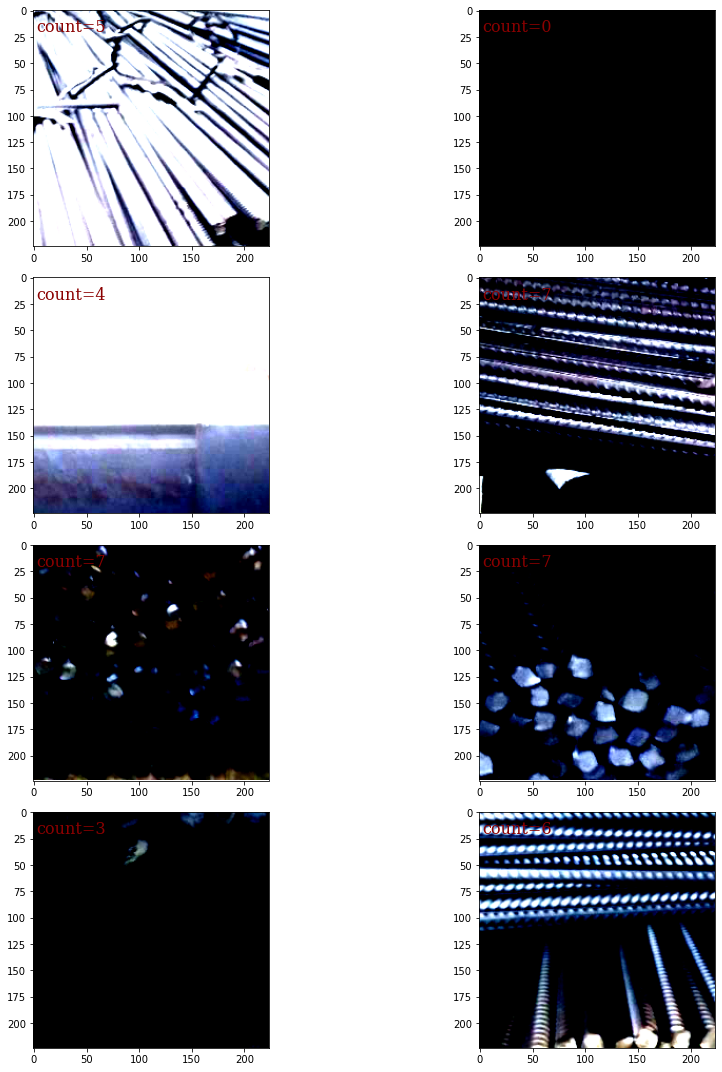

In [26]:
batch = dls.one_batch()[0]

font = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 16,
}

rows = 4
cols = 2
axes=[]
fig=plt.figure(figsize=(15,15))

for a in range(rows*cols):
    img = batch[a]
    img_arr = img.cpu()
    img_gray = rgb2gray(img_arr)
    blobs_dog = blob_dog(img_gray, max_sigma=30, threshold=.1)
    count = len(blobs_dog)
    
    axes.append(fig.add_subplot(rows, cols, a+1))
    plt.text(2, 20, r'count=' + str(count), fontdict=font)
    plt.imshow(img_arr.permute(1, 2, 0))
    
fig.tight_layout()    
plt.show()